In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models, layers, optimizers, metrics, preprocessing
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_df(path):
    data = list()
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for img in os.listdir(label_path):
                data.append({'Image Path': os.path.join(label_path, img), 'Class': label})
    return pd.DataFrame(data)

In [4]:
train_df = get_df(os.path.expanduser('~/medical-data/mri-dataset/Training'))
test_df = get_df(os.path.expanduser('~/medical-data/mri-dataset/Testing'))

# split into train, val, test sets
val_df, test_df = train_test_split(test_df, train_size=0.5, stratify=test_df['Class'], random_state=6)

In [5]:
train_df

,Image Path,Class
0,/Users/josephhu/medical-data/mri-dataset/Train...,pituitary
1,/Users/josephhu/medical-data/mri-dataset/Train...,pituitary
2,/Users/josephhu/medical-data/mri-dataset/Train...,pituitary
3,/Users/josephhu/medical-data/mri-dataset/Train...,pituitary
4,/Users/josephhu/medical-data/mri-dataset/Train...,pituitary
...,...,...
5707,/Users/josephhu/medical-data/mri-dataset/Train...,meningioma
5708,/Users/josephhu/medical-data/mri-dataset/Train...,meningioma
5709,/Users/josephhu/medical-data/mri-dataset/Train...,meningioma
5710,/Users/josephhu/medical-data/mri-dataset/Train...,meningioma


In [6]:
val_df

,Image Path,Class
148,/Users/josephhu/medical-data/mri-dataset/Testi...,pituitary
92,/Users/josephhu/medical-data/mri-dataset/Testi...,pituitary
1092,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
1285,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
574,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor
...,...,...
1143,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
1127,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
170,/Users/josephhu/medical-data/mri-dataset/Testi...,pituitary
494,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor


In [7]:
test_df

,Image Path,Class
644,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor
1216,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
616,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor
528,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor
543,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor
...,...,...
1164,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
1096,/Users/josephhu/medical-data/mri-dataset/Testi...,meningioma
53,/Users/josephhu/medical-data/mri-dataset/Testi...,pituitary
453,/Users/josephhu/medical-data/mri-dataset/Testi...,notumor


In [8]:
# data preprocessing

# with augmentation
gen1 = preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                brightness_range=(0.8, 1.2), 
                                width_shift_range=0.002, 
                                height_shift_range=0.002, 
                                rotation_range=10)

# no augmentation
gen2 = preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = gen1.flow_from_dataframe(train_df,
                                     x_col='Image Path',
                                     y_col='Class',
                                     batch_size=32,
                                     target_size=(299, 299))

val_gen = gen1.flow_from_dataframe(val_df,
                                   x_col='Image Path',
                                   y_col='Class',
                                   batch_size=32,
                                   target_size=(299, 299))

test_gen = gen2.flow_from_dataframe(test_df,
                                    x_col='Image Path',
                                    y_col='Class',
                                    batch_size=16,
                                    target_size=(299, 299),
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


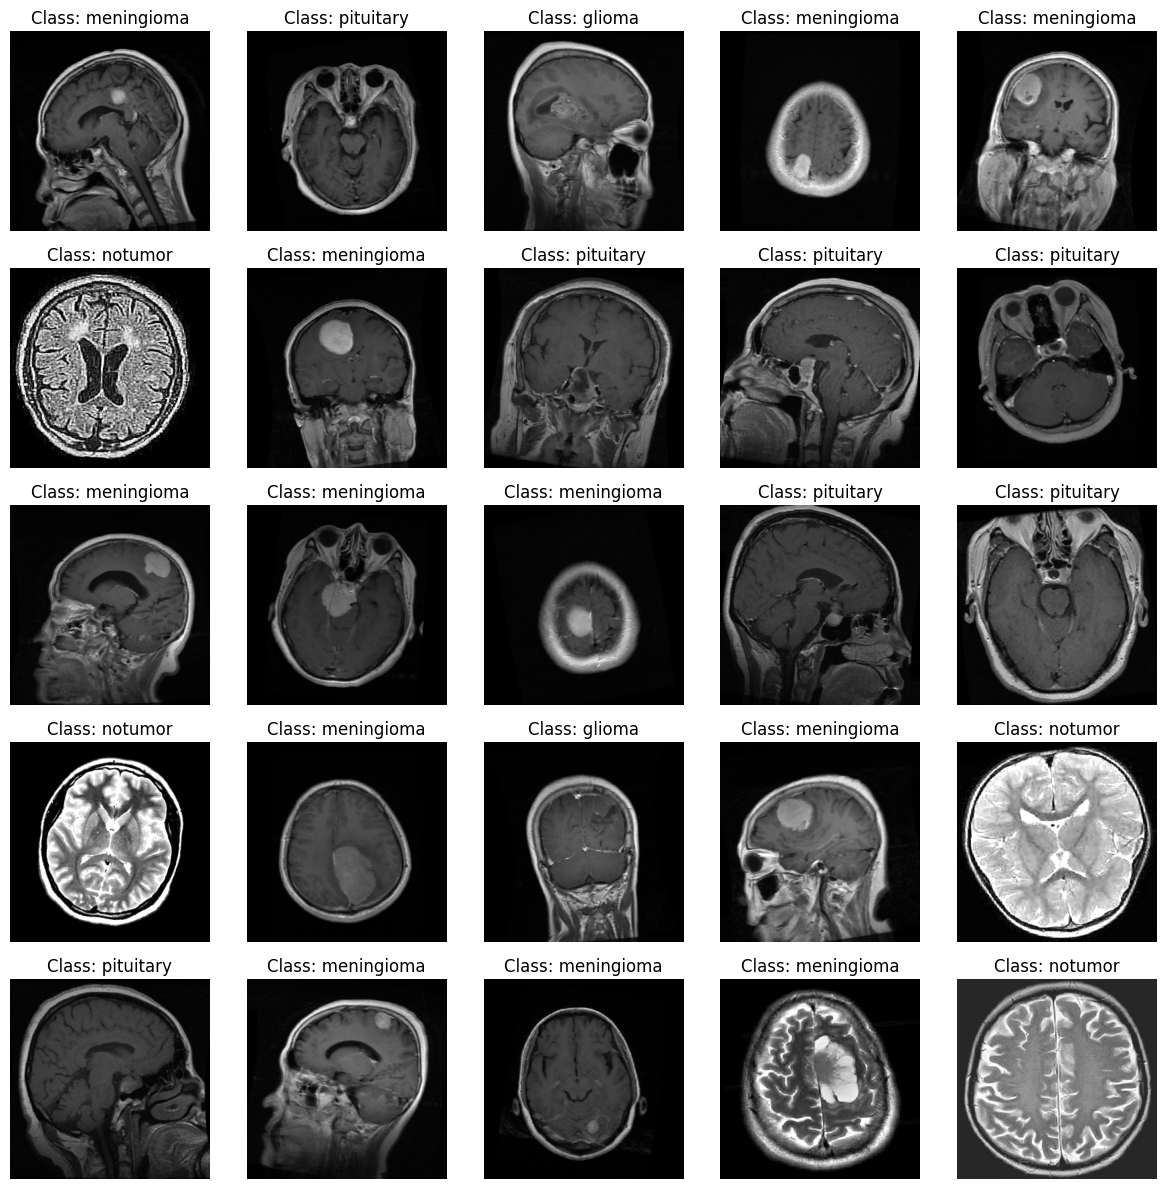

In [9]:
# sample data: images with their labels

classes_map = train_gen.class_indices
classes = list(classes_map.keys())
images, labels = next(train_gen)

plt.figure(figsize=(12, 12)) # figure size

for i in range(25): # ~25 images
    image = images[i]
    label = labels[i]
    
    plt.subplot(5, 5, i+1) # 5x5 layout
    plt.imshow(image)
    plt.title('Class: {}'.format(classes[np.argmax(label)]))
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
# construct model

pretrained_model = tf.keras.applications.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(299,299,3), 
    pooling='max'
)

model = models.Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dropout(rate=0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.25),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(), metrics.Recall()]
)

# test data to build model, using batch_size=1
test_data = tf.random.normal((1, 299, 299, 3))

# build model
model(test_data)

# get summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (1, 2048)              │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 2048)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 2048)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

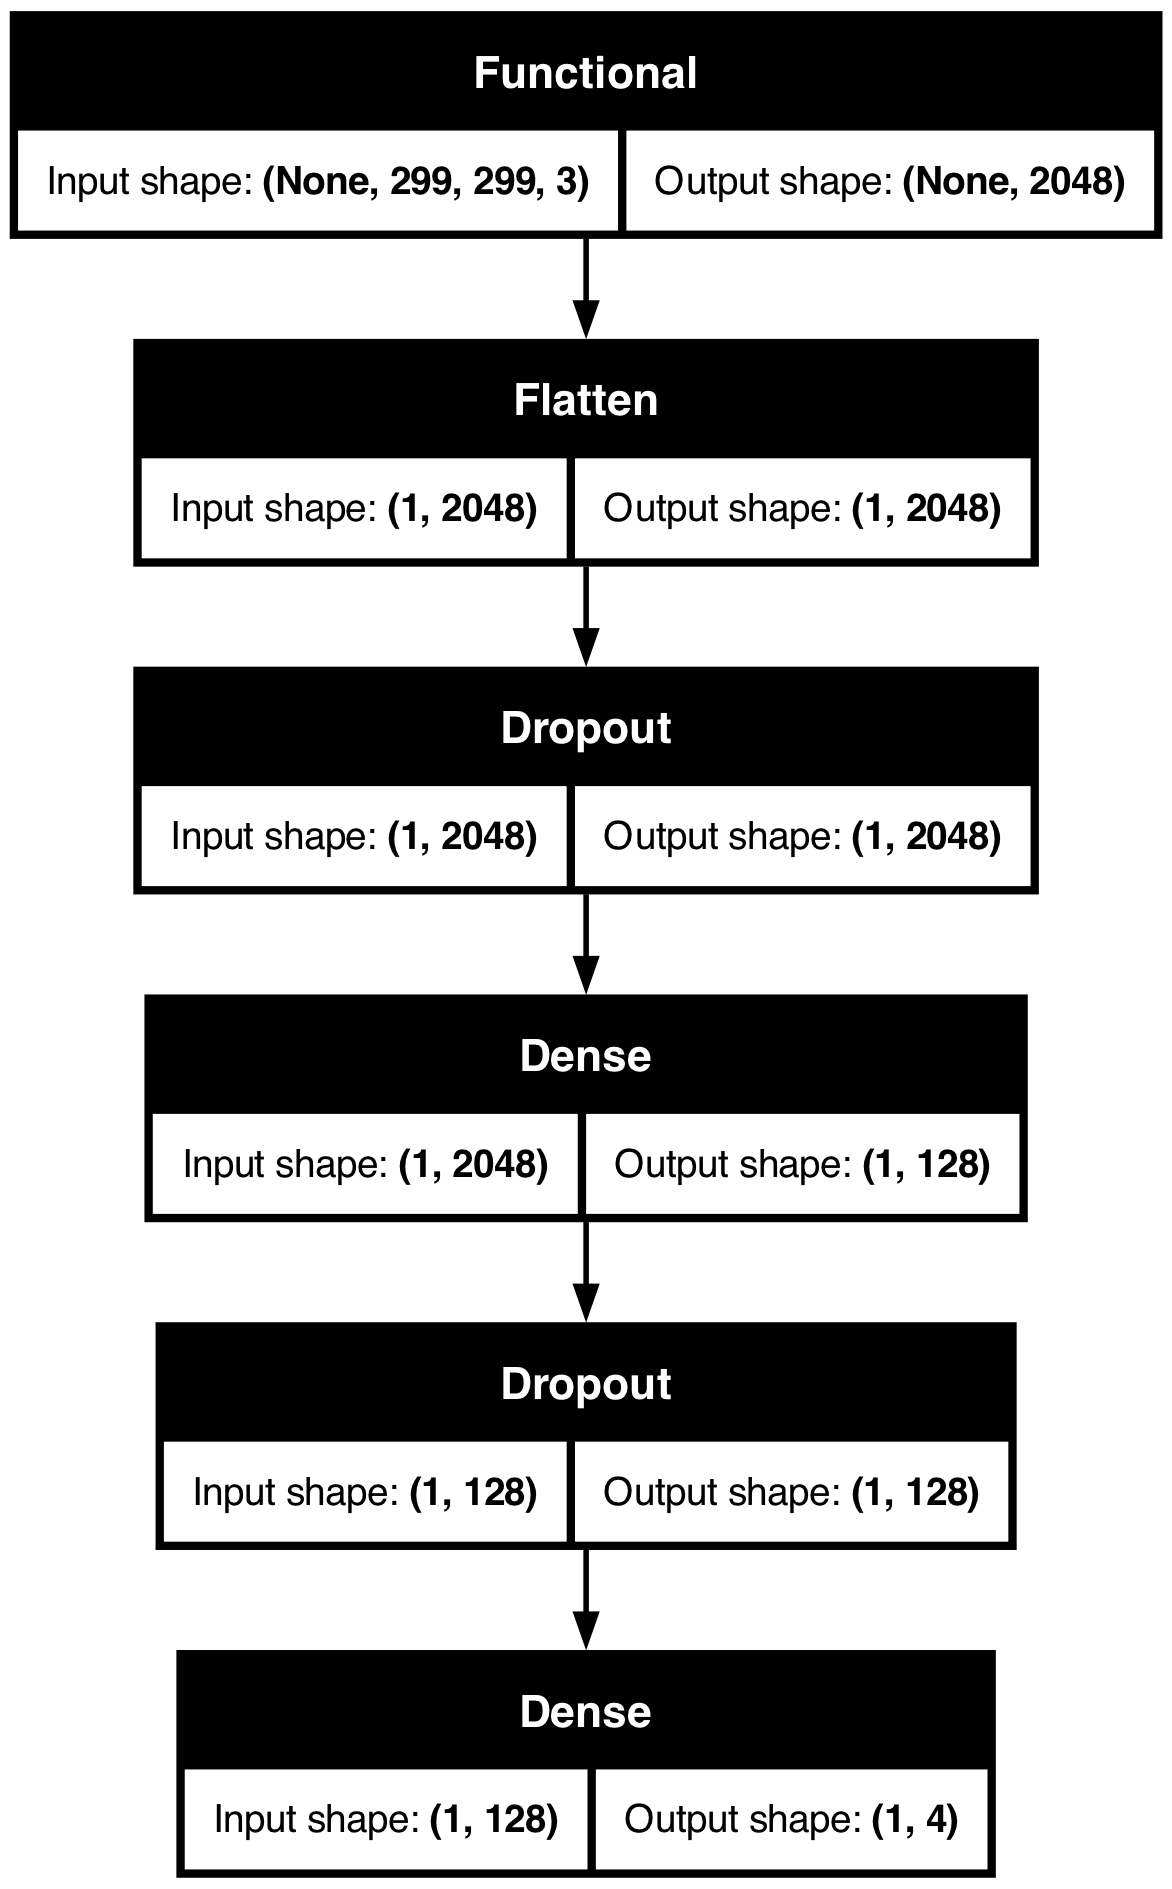

In [11]:
# visualize model
tf.keras.utils.plot_model(model, to_file='biohack-model.png', show_shapes=True)

In [12]:
# training
model_performance = model.fit(train_gen, epochs=10, validation_data=val_gen, shuffle=False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1061s 6s/step - accuracy: 0.7001 - loss: 0.8524 - precision: 0.7969 - recall: 0.5481 - val_accuracy: 0.9053 - val_loss: 0.2358 - val_precision: 0.9271 - val_recall: 0.8931
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1052s 6s/step - accuracy: 0.9627 - loss: 0.1203 - precision: 0.9660 - recall: 0.9600 - val_accuracy: 0.9634 - val_loss: 0.0858 - val_precision: 0.9647 - val_recall: 0.9603
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1055s 6s/step - accuracy: 0.9913 - loss: 0.0282 - precision: 0.9913 - recall: 0.9906 - val_accuracy: 0.9725 - val_loss: 0.0692 - val_precision: 0.9740 - val_recall: 0.9710
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1057s 6s/step - accuracy: 0.9953 - loss: 0.0185 - precision: 0.9960 - recall: 0.9949 - val_accuracy: 0.9588 - val_loss: 0.1646 - val_precision: 0.9602 - val_recall: 0.9588
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1055s 6s/step - accuracy: 0.9949 - loss: 0.0186 - precision: 0.9949 - recall: 0.9941 - val_accuracy: 0.9878 - va

In [13]:
# results
results = model.evaluate(test_gen, verbose=0)
print(f'Test Loss: {results[0]:0.4f}')
print(f'Test Accuracy: {results[1]:0.4f}')

Test Loss: 0.0963
Test Accuracy: 0.9665


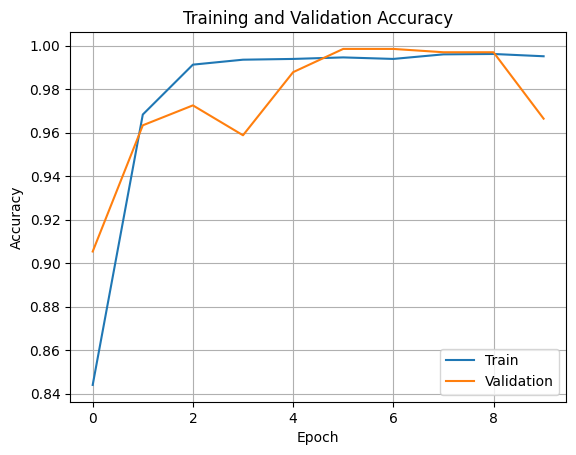

In [14]:
# train and val sets accuracy over epochs
plt.plot(model_performance.history['accuracy'])
plt.plot(model_performance.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

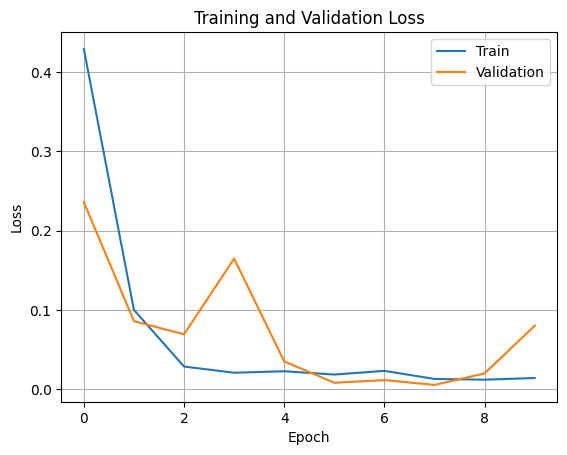

In [15]:
# train and val sets loss over epochs
plt.plot(model_performance.history['loss'])
plt.plot(model_performance.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 612ms/step


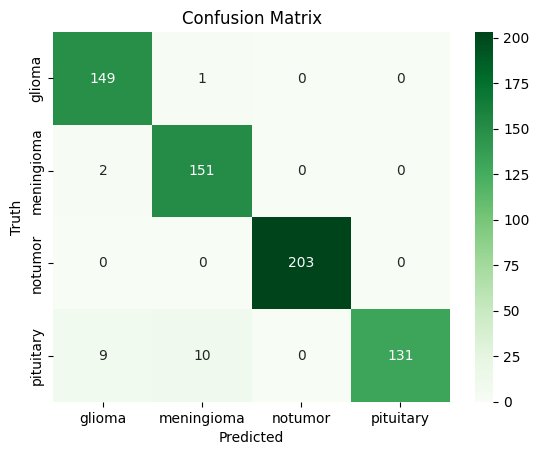

In [24]:
# confusion matrix
prediction = model.predict(test_gen)
y_pred = np.argmax(prediction, axis=1)
matrix = confusion_matrix(test_gen.classes, y_pred)
classes = list(train_gen.class_indices.keys())
sns.heatmap(matrix, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
# plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [57]:
def predict_tumor(img_path):
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    img = Image.open(img_path).resize((299, 299))
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2, 1, 2)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    prob = list(pred[0])
    bars = plt.barh(classes, prob)
    plt.xlabel('Probability')
    plt.gca().bar_label(bars, fmt='%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


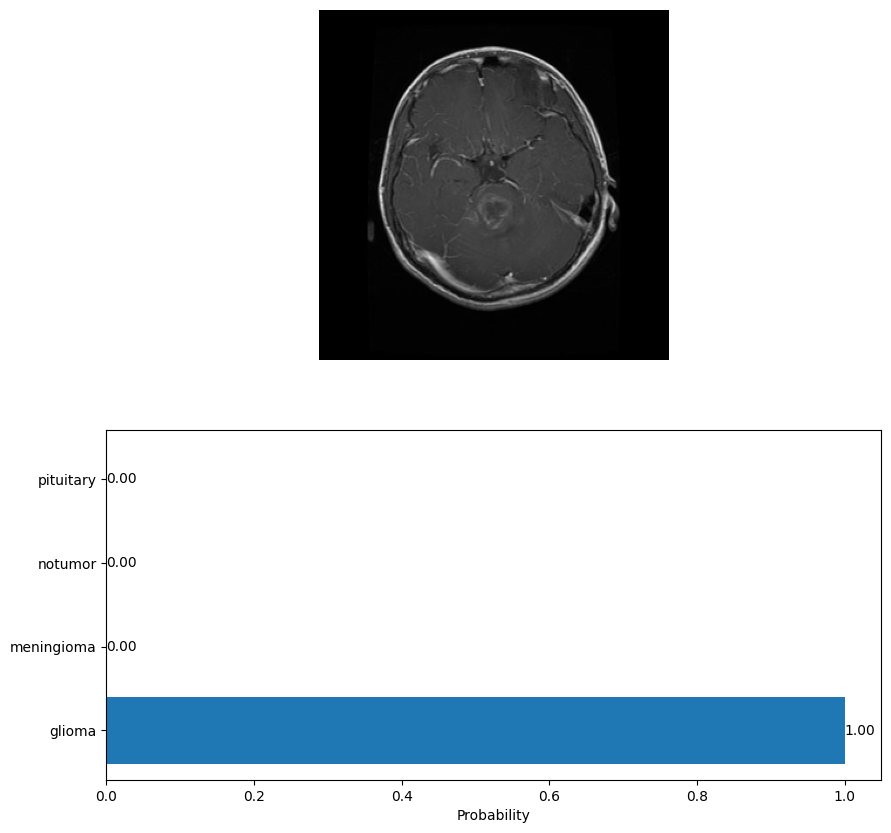

In [58]:
predict_tumor('/Users/josephhu/medical-data/mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


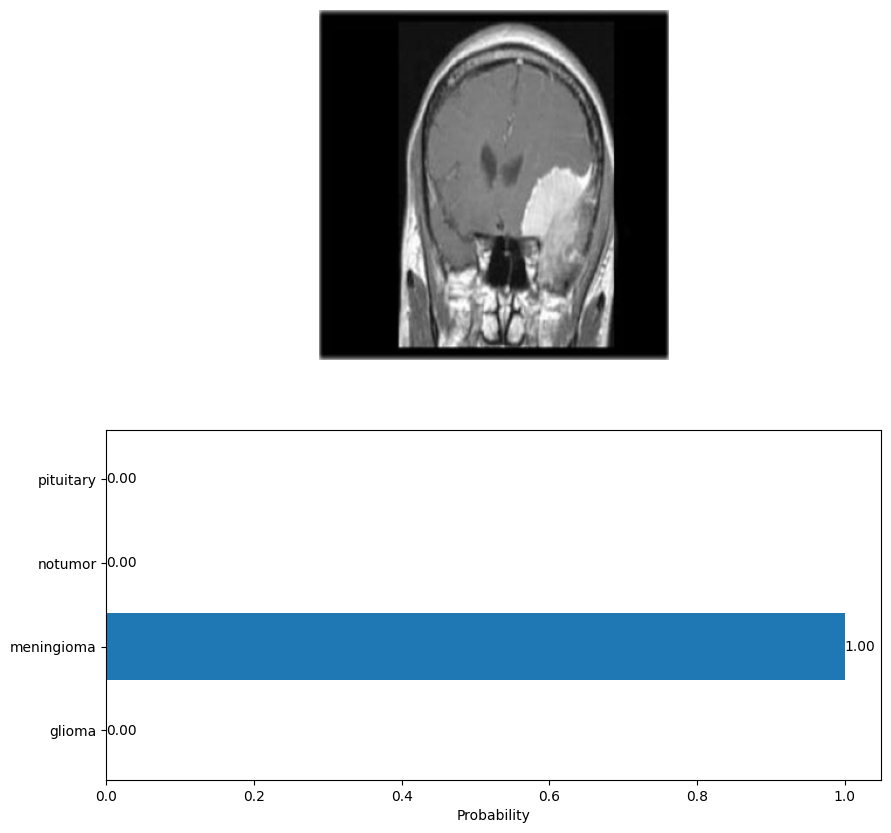

In [59]:
predict_tumor('/Users/josephhu/medical-data/mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [54]:
# saving model
model.save('biohack-model.keras')

In [56]:
list(train_gen.class_indices.keys())

['glioma', 'meningioma', 'notumor', 'pituitary']